# Draw Focus for spot grid 


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : June 29th 2020


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [4]:
import matplotlib.offsetbox
from matplotlib.lines import Line2D

In [5]:
class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={},textkw={} ,**kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False,textprops=textkw)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

## Constants for conversions

In [6]:
m_to_mm=1000.
mm_to_m=1e-3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [7]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [8]:
deg_to_rad=np.pi/180.

In [9]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_ro_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [10]:
Tel_Focal_Length=12.6 # m : Focal length of the telescope
Tel_Diameter=0.9 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter

#### filter

In [11]:
Filt_D=0.05769 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [12]:
Det_xpic=24.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=2512 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [13]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [14]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [15]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [16]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [17]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [18]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [19]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

# FLAG

Write the result of the Zshift scan in output file

- Not accurate scan : set Flag to False
- Accurate scan : set Flag to True

In [20]:
FLAG_WRITE=False

# Wavelength

In [21]:
ColorDict = {0.0004:"b",0.0006:"g",0.0008:"r",0.001:"k"}

# Read input files

In [22]:
def GetBeamParam(df):
    X0C=df["X0"].mean()
    Y0C=df["Y0"].mean()
    RXMAX=np.max(np.abs(df["X0"].values-X0C))
    RYMAX=np.max(np.abs(df["Y0"].values-Y0C))   
    RMAX=np.max(np.array([RXMAX,RYMAX]))
    return X0C,Y0C,RMAX

In [23]:
def Select_Beam(row):
    return (row["X0"]-X0C)**2+(row["Y0"]-Y0C)**2 <= RMAX**2

In [24]:
#rayfile_hoe=Beam4_Rayfile+"_RAY_HOE_OUT.xlsx"
#rayfile_R400=Beam4_Rayfile+"_RAY_RON400_OUT.xlsx"
#rayfile_R350=Beam4_Rayfile+"_RAY_RON350_OUT.xlsx"
#rayfile_R200=Beam4_Rayfile+"_RAY_RON200_OUT.xlsx"

In [25]:
rayfile_hoe="HOE_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R200="R200_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R350="R350_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R400="R400_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R300="R300_Beam4_Rayfile_484_allwl_m00_m00_2020_05_31_B4OUT_RAY.xlsx"

## read HOE

In [26]:
input_hoe = pd.ExcelFile(rayfile_hoe)
df_hoe = input_hoe.parse(index_row=0,header=1)
df_hoe=df_hoe.iloc[0:NBTOT]

In [27]:
# rename columns otherwise they are not recognize and swap X,Y
#df_hoe.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]
#df_hoe.columns = ["Y0","X0","Z0","V0","U0","W0","wave","Y1","X1","Z1","Y2","X2","Z2","Y3","X3","Z3","Yfinal","Xfinal","Zfinal","Notes"]

In [28]:
df_hoe

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,8.27790,-0.01283,79.99998,0,0,8.27790,-0.01283,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,8.28523,-0.01285,79.99998,0,0,8.28523,-0.01285,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,8.29260,-0.01287,79.99998,0,0,8.29260,-0.01287,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842679,-2.10670,...,8.30001,-0.01289,79.99998,0,0,8.30001,-0.01289,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,8.30745,-0.01291,79.99998,0,0,8.30745,-0.01291,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,21.97558,-0.05372,79.99998,0,0,21.97558,-0.05372,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842679,2.10670,...,21.94330,-0.05361,79.99998,0,0,21.94330,-0.05361,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,21.91098,-0.05350,79.99998,0,0,21.91098,-0.05350,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,21.87866,-0.05338,79.99998,0,0,21.87866,-0.05338,80,OK,3


In [29]:
X0C,Y0C,RMAX=GetBeamParam(df_hoe)

In [30]:
df_filter=df_hoe.copy()
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
df_filter=df_filter.reset_index()   # reset index
df_hoe=df_filter.copy()

Text(0.5, 0.98, 'HOE Filtered circular beam')

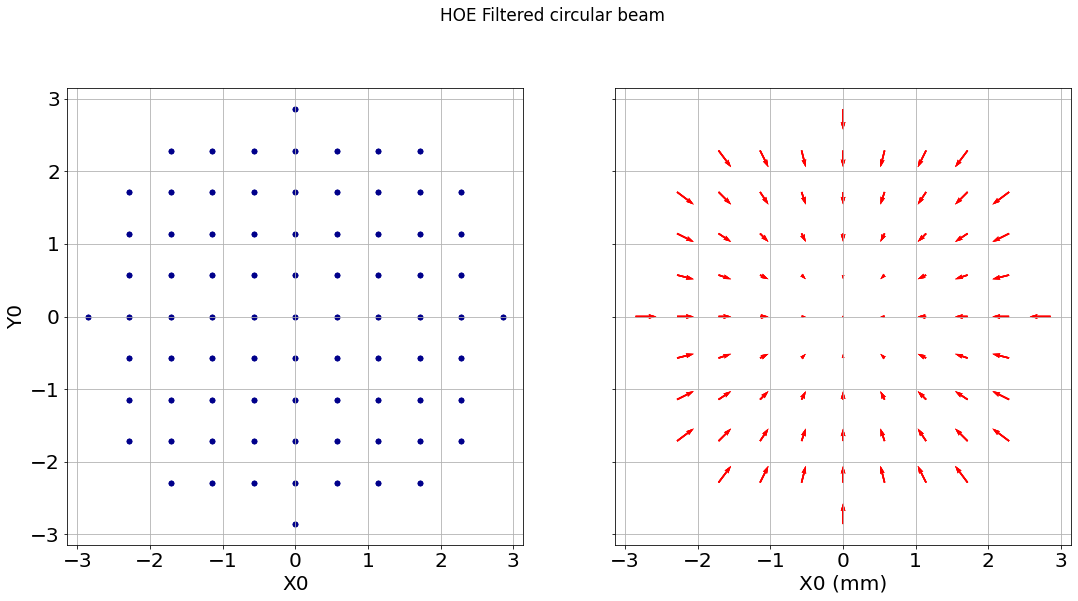

In [31]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(df_filter["X0"], df_filter["Y0"], df_filter["U0"], df_filter["V0"],color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("HOE Filtered circular beam")

## read R400

In [32]:
input_R400 = pd.ExcelFile(rayfile_R400)
df_R400 = input_R400.parse(index_row=0,header=1)
df_R400=df_R400.iloc[0:NBTOT]

In [33]:
# rename columns otherwise they are not recognize
#df_R400.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]

In [34]:
df_R400

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,9.50870,0.03953,80,0,0,9.50870,0.03953,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,9.48531,0.03701,80,0,0,9.48531,0.03701,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,9.46349,0.03451,80,0,0,9.46349,0.03451,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,9.44321,0.03201,80,0,0,9.44321,0.03201,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,9.42447,0.02953,80,0,0,9.42447,0.02953,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,25.21121,-0.18127,80,0,0,25.21121,-0.18127,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,25.09532,-0.17373,80,0,0,25.09532,-0.17373,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,24.98470,-0.16628,80,0,0,24.98470,-0.16628,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,24.87929,-0.15892,80,0,0,24.87929,-0.15892,80,OK,3


In [35]:
X0C,Y0C,RMAX=GetBeamParam(df_R400)

In [36]:
df_filter=df_R400.copy()
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
df_filter=df_filter.reset_index()   # reset index
df_R400=df_filter.copy()

Text(0.5, 0.98, 'R400 Filtered circular beam')

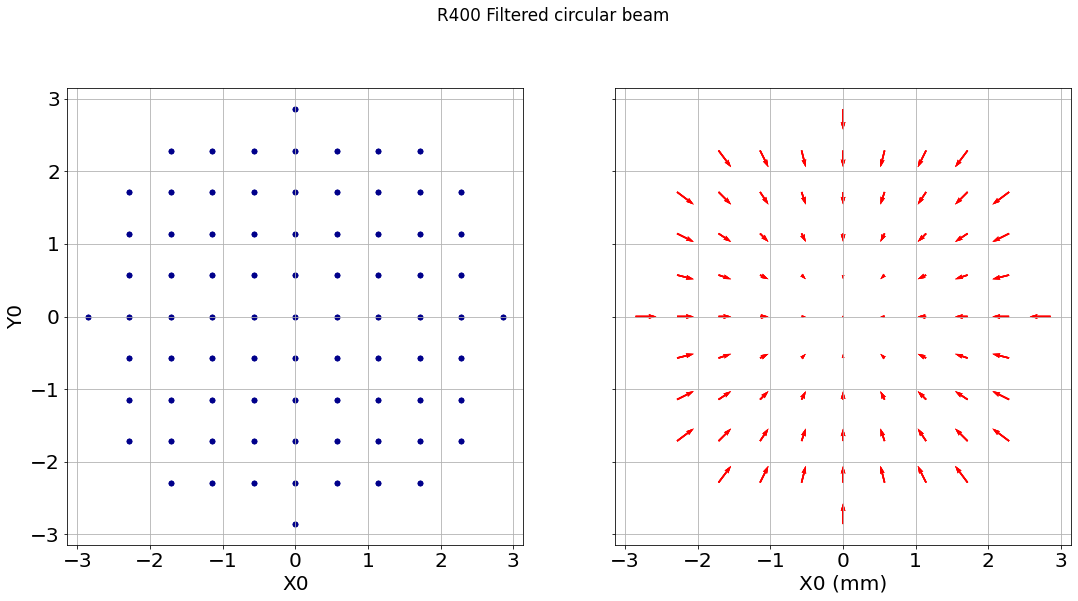

In [37]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(df_filter["X0"], df_filter["Y0"], df_filter["U0"], df_filter["V0"],color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("R400 Filtered circular beam")

## Read R200

In [38]:
input_R200 = pd.ExcelFile(rayfile_R200)
df_R200 = input_R200.parse(index_row=0,header=1)
df_R200=df_R200.iloc[0:NBTOT]

In [39]:
# rename columns otherwise they are not recognize
#df_R200.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]

In [40]:
df_R200

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,4.68705,0.01269,80,0,0,4.68705,0.01269,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,4.67976,0.01147,80,0,0,4.67976,0.01147,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,4.67321,0.01027,80,0,0,4.67321,0.01027,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,4.66738,0.00906,80,0,0,4.66738,0.00906,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,4.66228,0.00786,80,0,0,4.66228,0.00786,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,11.82185,-0.03962,80,0,0,11.82185,-0.03962,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,11.79859,-0.03650,80,0,0,11.79859,-0.03650,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,11.77726,-0.03340,80,0,0,11.77726,-0.03340,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,11.75785,-0.03031,80,0,0,11.75785,-0.03031,80,OK,3


In [41]:
X0C,Y0C,RMAX=GetBeamParam(df_R200)

In [42]:
df_filter=df_R200.copy()
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
df_filter=df_filter.reset_index()   # reset index
df_R200=df_filter.copy()

Text(0.5, 0.98, 'R200 Filtered circular beam')

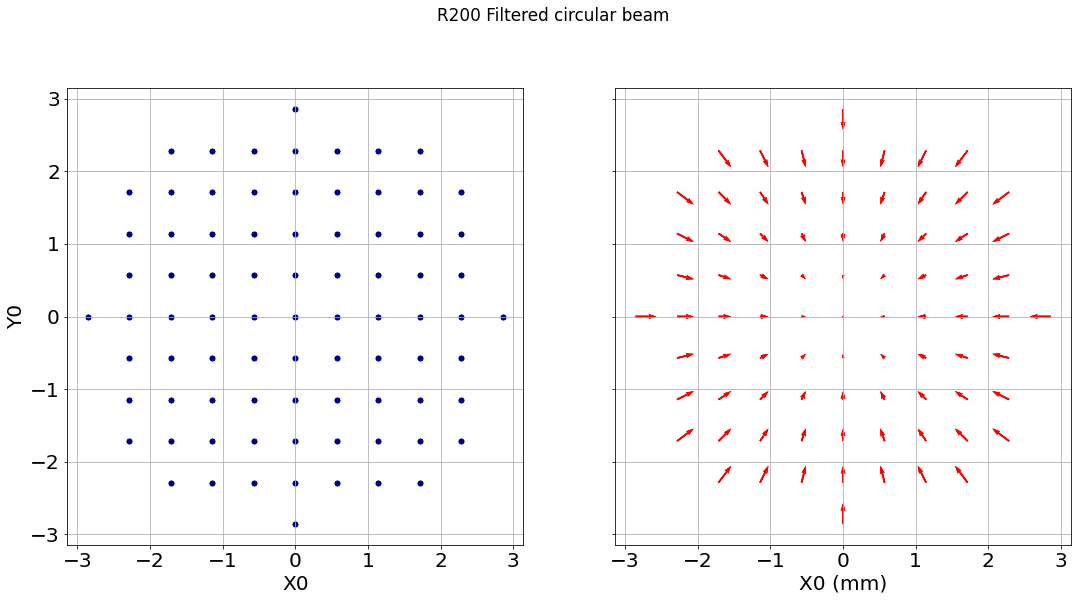

In [43]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(df_filter["X0"], df_filter["Y0"], df_filter["U0"], df_filter["V0"],color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("R200 Filtered circular beam")

## Read R350

In [44]:
input_R350 = pd.ExcelFile(rayfile_R350)
df_R350 = input_R350.parse(index_row=0,header=1)
df_R350=df_R350.iloc[0:NBTOT]

In [45]:
df_R350

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,8.28509,0.03142,80,0,0,8.28509,0.03142,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,8.26662,0.02923,80,0,0,8.26662,0.02923,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,8.24951,0.02707,80,0,0,8.24951,0.02707,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,8.23371,0.02491,80,0,0,8.23371,0.02491,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,8.21925,0.02276,80,0,0,8.21925,0.02276,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,21.59873,-0.13376,80,0,0,21.59873,-0.13376,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,21.51529,-0.12756,80,0,0,21.51529,-0.12756,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,21.43600,-0.12143,80,0,0,21.43600,-0.12143,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,21.36083,-0.11535,80,0,0,21.36083,-0.11535,80,OK,3


In [46]:
X0C,Y0C,RMAX=GetBeamParam(df_R350)

In [47]:
df_filter=df_R350.copy()
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
df_filter=df_filter.reset_index()   # reset index
df_R350=df_filter.copy()

In [48]:
df_R350

,index,X0,Y0,Z0,U0,V0,W0,wave,col,X1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,5,0.000000,-2.856536,0,0.000000,0.035684,0.999363,0.0004,b,0.000000,...,8.20610,0.02063,80,0,0,8.20610,0.02063,80,OK,3
1,13,-1.713921,-2.285228,0,0.021410,0.028547,0.999363,0.0004,b,-1.264016,...,8.24757,0.02165,80,0,0,8.24757,0.02165,80,OK,3
2,14,-1.142614,-2.285228,0,0.014275,0.028551,0.999490,0.0004,b,-0.842678,...,8.23179,0.01992,80,0,0,8.23179,0.01992,80,OK,3
3,15,-0.571307,-2.285228,0,0.007138,0.028553,0.999567,0.0004,b,-0.421340,...,8.21732,0.01821,80,0,0,8.21732,0.01821,80,OK,3
4,16,0.000000,-2.285228,0,0.000000,0.028554,0.999592,0.0004,b,0.000000,...,8.20418,0.01649,80,0,0,8.20418,0.01649,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,467,0.000000,2.285228,0,0.000000,-0.028554,0.999592,0.0010,k,0.000000,...,21.68075,-0.11197,80,0,0,21.68075,-0.11197,80,OK,3
320,468,0.571307,2.285228,0,-0.007138,-0.028553,0.999567,0.0010,k,0.421340,...,21.59312,-0.10696,80,0,0,21.59312,-0.10696,80,OK,3
321,469,1.142614,2.285228,0,-0.014275,-0.028551,0.999490,0.0010,k,0.842678,...,21.50971,-0.10200,80,0,0,21.50971,-0.10200,80,OK,3
322,470,1.713921,2.285228,0,-0.021410,-0.028547,0.999363,0.0010,k,1.264016,...,21.43048,-0.09709,80,0,0,21.43048,-0.09709,80,OK,3


Text(0.5, 0.98, 'R350 Filtered circular beam')

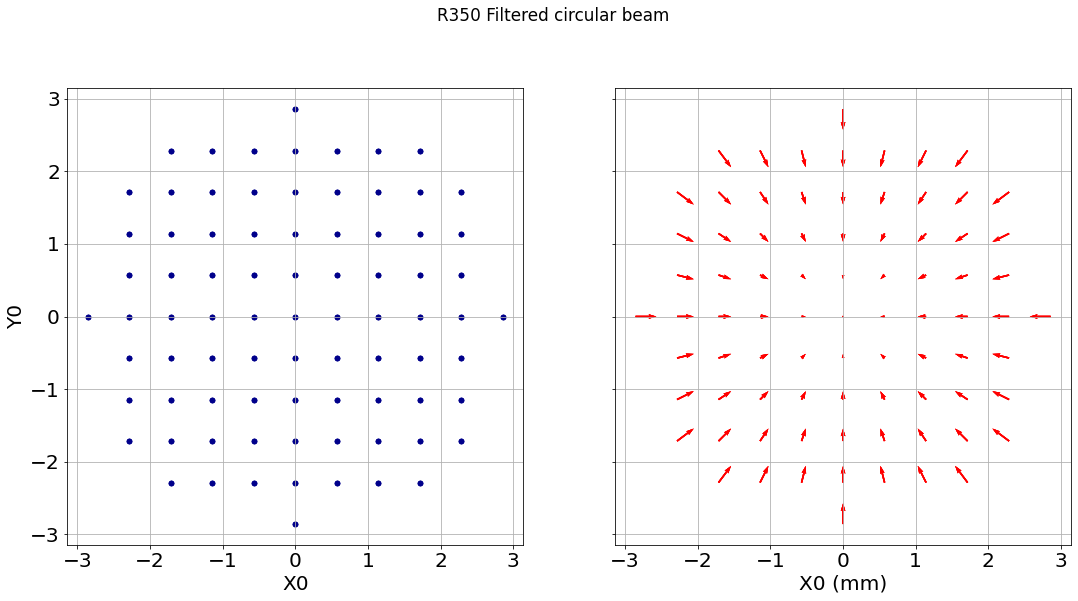

In [49]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(df_filter["X0"], df_filter["Y0"], df_filter["U0"], df_filter["V0"],color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("R350 Filtered circular beam")

## Read R300

In [50]:
input_R300 = pd.ExcelFile(rayfile_R300)
df_R300 = input_R300.parse(index_row=0,header=1)
df_R300=df_R300.iloc[0:NBTOT]

In [51]:
df_R300

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,7.07474,0.02426,80,0,0,7.07474,0.02426,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,7.06058,0.02241,80,0,0,7.06058,0.02241,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,7.04756,0.02057,80,0,0,7.04756,0.02057,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,7.03565,0.01874,80,0,0,7.03565,0.01874,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,7.02487,0.01691,80,0,0,7.02487,0.01691,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,18.19158,-0.09504,80,0,0,18.19158,-0.09504,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,18.13355,-0.08999,80,0,0,18.13355,-0.08999,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,18.07880,-0.08500,80,0,0,18.07880,-0.08500,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,18.02729,-0.08003,80,0,0,18.02729,-0.08003,80,OK,3


In [52]:
X0C,Y0C,RMAX=GetBeamParam(df_R300)

In [53]:
df_filter=df_R300.copy()
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
df_filter=df_filter.reset_index()   # reset index
df_R300=df_filter.copy()

Text(0.5, 0.98, 'R300 Filtered circular beam')

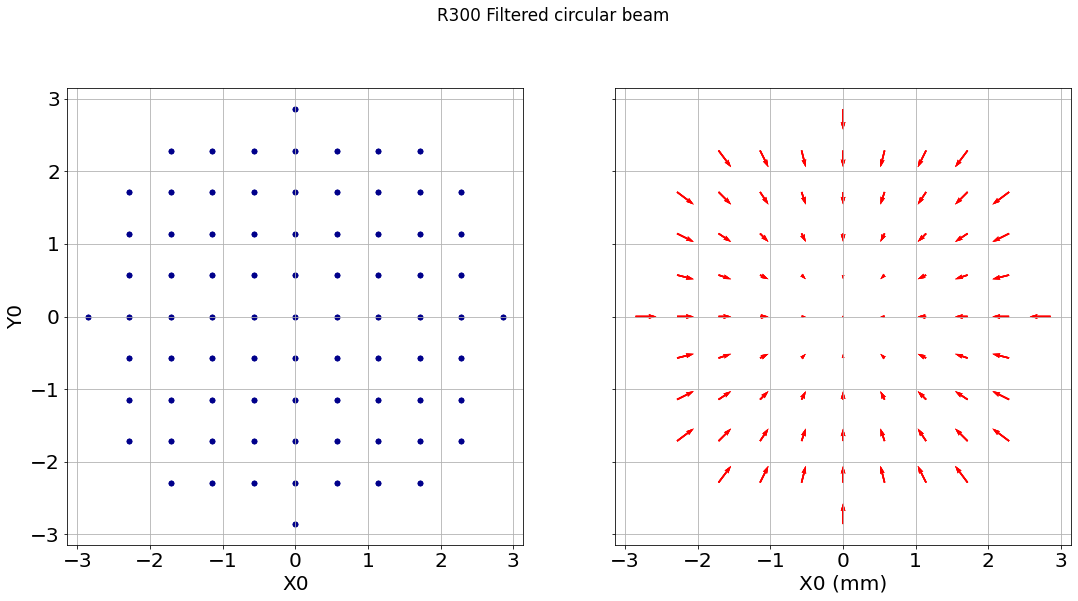

In [54]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(df_filter["X0"], df_filter["Y0"], df_filter["U0"], df_filter["V0"],color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("R300 Filtered circular beam")

# Compute straight line parameters for each ray

In [55]:
def norm(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

In [56]:
def norm_row(row):
    DX=row["X3"]-row["X2"]
    DY=row["Y3"]-row["Y2"]
    DZ=row["Z3"]-row["Z2"]
    return norm(DX,DY,DZ)

In [57]:
def u_row(row):
    norm=norm_row(row)
    DX=row["X3"]-row["X2"]
    return DX/norm

In [58]:
def v_row(row):
    norm=norm_row(row)
    DY=row["Y3"]-row["Y2"]
    return DY/norm

In [59]:
def w_row(row):
    norm=norm_row(row)
    DZ=row["Z3"]-row["Z2"]
    return DZ/norm

In [60]:
def norm_check(row):
    return norm(row["Uf"],row["Vf"],row["Wf"])

In [61]:
df_hoe["Uf"]=df_hoe.apply(u_row,axis=1)
df_hoe["Vf"]=df_hoe.apply(v_row,axis=1)
df_hoe["Wf"]=df_hoe.apply(w_row,axis=1)

In [62]:
#df_hoe.apply(norm_check,axis=1)

In [63]:
df_R400["Uf"]=df_R400.apply(u_row,axis=1)
df_R400["Vf"]=df_R400.apply(v_row,axis=1)
df_R400["Wf"]=df_R400.apply(w_row,axis=1)

In [64]:
#df_R400.apply(norm_check,axis=1)

In [65]:
df_R200["Uf"]=df_R200.apply(u_row,axis=1)
df_R200["Vf"]=df_R200.apply(v_row,axis=1)
df_R200["Wf"]=df_R200.apply(w_row,axis=1)

In [66]:
#df_R200.apply(norm_check,axis=1)

In [67]:
df_R350["Uf"]=df_R350.apply(u_row,axis=1)
df_R350["Vf"]=df_R350.apply(v_row,axis=1)
df_R350["Wf"]=df_R350.apply(w_row,axis=1)

In [68]:
df_R300["Uf"]=df_R300.apply(u_row,axis=1)
df_R300["Vf"]=df_R300.apply(v_row,axis=1)
df_R300["Wf"]=df_R300.apply(w_row,axis=1)

Text(0, 0.5, 'Y (mm)')

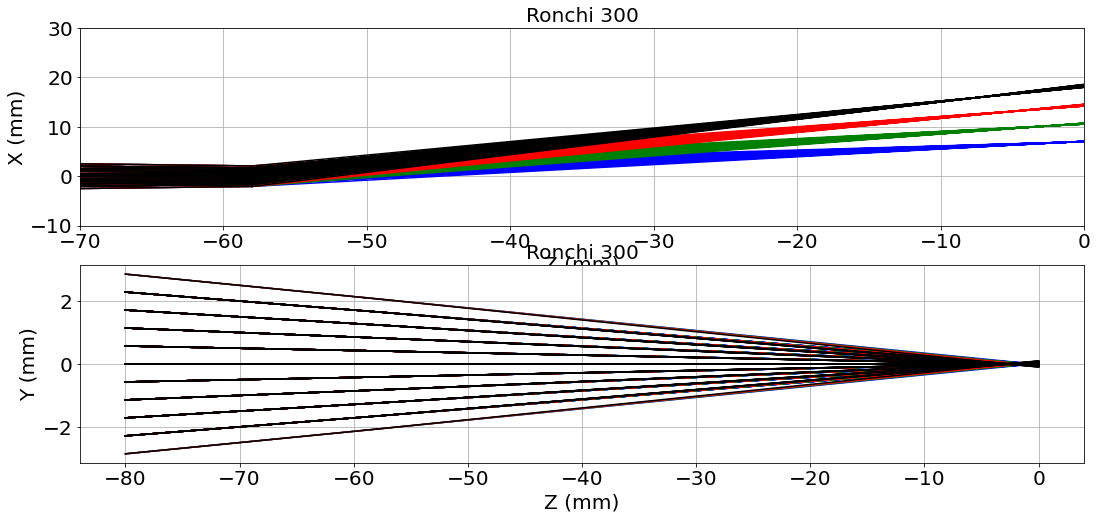

In [69]:
#fig=plt.figure(figsize=(16,8))
fig, ((ax1, ax2)) = plt.subplots(2,1,figsize=(18,8))

for index, row in df_R300.iterrows():
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]
    
    ax1.plot([Z0,Z1],[X0,X1],"-",color=col)
    ax1.plot([Z1,Z2],[X1,X2],"-",color=col)
    ax1.plot([Z2,Z3],[X2,X3],"-",color=col)

ax1.grid()
ax1.set_xlim(-70,0)
ax1.set_ylim(-10,30)
ax1.set_title("Ronchi 300")   
ax1.set_xlabel("Z (mm)")
ax1.set_ylabel("X (mm)")  
#ax1.set_aspect('equal')

for index, row in df_R300.iterrows():
     
    wl=row["wave"]
    col=ColorDict[wl]
    X0=row["X0"];Y0=row["Y0"];Z0=row["Z0"]-row["Z3"]
    X1=row["X1"];Y1=row["Y1"];Z1=row["Z1"]-row["Z3"]
    X2=row["X2"];Y2=row["Y2"];Z2=row["Z2"]-row["Z3"]
    X3=row["X3"];Y3=row["Y3"];Z3=row["Z3"]-row["Z3"]

    ax2.plot([Z0,Z1],[Y0,Y1],"-",color=col)
    ax2.plot([Z1,Z2],[Y1,Y2],"-",color=col)
    ax2.plot([Z2,Z3],[Y2,Y3],"-",color=col)

ax2.grid()
#ax2.set_xlim(-70,0)
#ax2.set_ylim(-10,30)
ax2.set_title("Ronchi 300")   
ax2.set_xlabel("Z (mm)")
ax2.set_ylabel("Y (mm)")  
#ax1.set_aspect('equal')

Text(0.5, 0.98, 'Direction of beams')

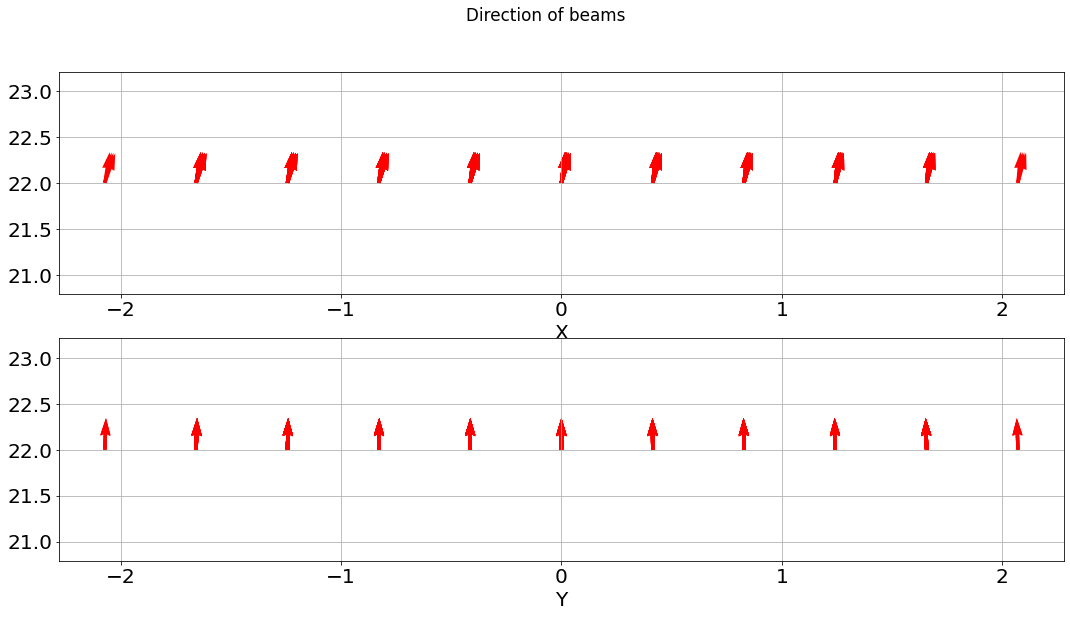

In [70]:
f, ((ax1, ax2)) = plt.subplots(2,1,figsize=(18,9))

q = ax1.quiver(df_R300["X2"], df_R300["Z2"], df_R300["Uf"], df_R300["Wf"],color="red")
#ax1.set_aspect("equal")
ax1.set_xlabel("X")
ax1.grid()
q = ax2.quiver(df_R300["Y2"], df_R300["Z2"], df_R300["Vf"], df_R300["Wf"],color="red")
ax2.grid()
ax2.set_xlabel("Y")
plt.suptitle("Direction of beams")

# Compute the intersection points (Xi,Yi) with the plane Z=Zi

In [71]:
def xi_row(row):
    k=(row["Zi"]-row["Z3"])/row["Wf"]
    xi=row["X3"]+ k*row["Uf"]
    return xi

In [72]:
def yi_row(row):
    k=(row["Zi"]-row["Z3"])/row["Wf"]
    yi=row["Y3"]+ k*row["Vf"]
    return yi

In [73]:
df_hoe["Zi"]=df_hoe["Z3"]+1 

In [74]:
df_hoe["Xi"]=df_hoe.apply(xi_row,axis=1)
df_hoe["Yi"]=df_hoe.apply(yi_row,axis=1)

In [75]:
df_hoe

,index,X0,Y0,Z0,U0,V0,W0,wave,col,X1,...,Yfinal,Zfinal,Notes,Unnamed: 23,Uf,Vf,Wf,Zi,Xi,Yi
0,5,0.000000,-2.856536,0,0.000000,0.035684,0.999363,0.0004,b,0.000000,...,-0.01292,80,OK,3,0.141823,0.035103,0.989269,80.99998,8.458301,0.022564
1,13,-1.713921,-2.285228,0,0.021410,0.028547,0.999363,0.0004,b,-1.264016,...,-0.01029,80,OK,3,0.162158,0.028001,0.986367,80.99998,8.456959,0.018098
2,14,-1.142614,-2.285228,0,0.014275,0.028551,0.999490,0.0004,b,-0.842678,...,-0.01031,80,OK,3,0.155411,0.028031,0.987452,80.99998,8.457356,0.018078
3,15,-0.571307,-2.285228,0,0.007138,0.028553,0.999567,0.0004,b,-0.421340,...,-0.01032,80,OK,3,0.148642,0.028061,0.988493,80.99998,8.457783,0.018067
4,16,0.000000,-2.285228,0,0.000000,0.028554,0.999592,0.0004,b,0.000000,...,-0.01034,80,OK,3,0.141854,0.028089,0.989489,80.99998,8.458260,0.018047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,467,0.000000,2.285228,0,0.000000,-0.028554,0.999592,0.0010,k,0.000000,...,-0.04306,80,OK,3,0.354634,-0.027391,0.934604,80.99998,22.387438,-0.072368
320,468,0.571307,2.285228,0,-0.007138,-0.028553,0.999567,0.0010,k,0.421340,...,-0.04298,80,OK,3,0.348321,-0.027459,0.936973,80.99998,22.347491,-0.072286
321,469,1.142614,2.285228,0,-0.014275,-0.028551,0.999490,0.0010,k,0.842678,...,-0.04289,80,OK,3,0.341959,-0.027526,0.939312,80.99998,22.307493,-0.072195
322,470,1.713921,2.285228,0,-0.021410,-0.028547,0.999363,0.0010,k,1.264016,...,-0.04280,80,OK,3,0.335550,-0.027593,0.941618,80.99998,22.267474,-0.072103


In [76]:
df_hoe.groupby(["wave"]).mean()

,index,X0,Y0,Z0,U0,V0,W0,X1,Y1,Z1,...,Xfinal,Yfinal,Zfinal,Unnamed: 23,Uf,Vf,Wf,Zi,Xi,Yi
wave,,,,,,,,,,,,,,,,,,,,,
0.0004,60,2.741291e-18,-3.289550e-17,0,4.283268e-20,-8.566536e-20,0.999669,8.223874e-18,8.223874e-17,21,...,8.314969,-1.499144e-19,80,3,0.141823,8.566536e-20,0.989576,80.99998,8.458331,-9.423189e-19
0.0006,181,2.741291e-18,-3.289550e-17,0,4.283268e-20,-8.566536e-20,0.999669,8.223874e-18,8.223874e-17,21,...,12.635639,1.606225e-20,80,3,0.212734,-2.569961e-19,0.976796,80.99998,12.853495,5.139921e-19
0.0008,302,2.741291e-18,-3.289550e-17,0,4.283268e-20,-8.566536e-20,0.999669,8.223874e-18,8.223874e-17,21,...,17.167191,-8.566536e-19,80,3,0.283646,1.970303e-18,0.958614,80.99998,17.463177,1.970303e-18
0.0010,423,2.741291e-18,-3.289550e-17,0,4.283268e-20,-8.566536e-20,0.999669,8.223874e-18,8.223874e-17,21,...,22.008016,2.826957e-18,80,3,0.354557,0.000000e+00,0.934714,80.99998,22.387464,3.426614e-18


In [77]:
df_hoe.groupby(["wave"]).std()

,index,X0,Y0,Z0,U0,V0,W0,X1,Y1,Z1,...,Xfinal,Yfinal,Zfinal,Unnamed: 23,Uf,Vf,Wf,Zi,Xi,Yi
wave,,,,,,,,,,,,,,,,,,,,,
0.0004,28.322253,1.464932,1.464932,0.0,0.018304,0.018304,0.000195,1.080387,1.08039,0.0,...,0.019230,0.006625,0.0,0.0,0.017433,0.018006,0.002504,0.0,0.001254,0.011573
0.0006,28.322253,1.464932,1.464932,0.0,0.018304,0.018304,0.000195,1.080387,1.08039,0.0,...,0.004841,0.001660,0.0,0.0,0.016998,0.017857,0.003704,0.0,0.013387,0.016623
0.0008,28.322253,1.464932,1.464932,0.0,0.018304,0.018304,0.000195,1.080387,1.08039,0.0,...,0.027806,0.009442,0.0,0.0,0.016563,0.017708,0.004900,0.0,0.046597,0.027917
0.0010,28.322253,1.464932,1.464932,0.0,0.018304,0.018304,0.000195,1.080387,1.08039,0.0,...,0.082639,0.027600,0.0,0.0,0.016128,0.017559,0.006116,0.0,0.102376,0.046387


In [78]:
df_hoe.groupby(["wave"]).std()["Xi"]

wave
0.0004    0.001254
0.0006    0.013387
0.0008    0.046597
0.0010    0.102376
Name: Xi, dtype: float64

In [79]:
df_hoe.groupby(["wave"]).std().iloc[0]

index          28.322253
X0              1.464932
Y0              1.464932
Z0              0.000000
U0              0.018304
V0              0.018304
W0              0.000195
X1              1.080387
Y1              1.080390
Z1              0.000000
X2              1.062075
Y2              1.062075
Z2              0.000000
X3              0.019230
Y3              0.006625
Z3              0.000000
Xgoal           0.000000
Ygoal           0.000000
Xfinal          0.019230
Yfinal          0.006625
Zfinal          0.000000
Unnamed: 23     0.000000
Uf              0.017433
Vf              0.018006
Wf              0.002504
Zi              0.000000
Xi              0.001254
Yi              0.011573
Name: 0.0004, dtype: float64

# Beam spot function

## Extract X,Y for a given defocus

In [80]:
def GetBeamSpot(dfin,defocus,wave):
    """
    
    GetBeamSpot(df,defocus) : compute defocus
    
    input arg :
      - df : dataframe
      - defocus : in mm
      - wave:   0.0004,  0.0006,  0.0008,  0.001
      
    output arg :
      all_Xi
      all_yi
     
    """
    df=dfin.copy()
    df=df.loc[df["wave"]==wave]
    
    if len(df) ==0:
        print("GetBeamSpot(df,defocus,wave) : error on wave")
        return
    
    df["Zi"]=df["Z3"]+defocus 
    # compute intersection points with the new detection plane
    df["Xi"]=df.apply(xi_row,axis=1)
    df["Yi"]=df.apply(yi_row,axis=1)
    
    df0=df.loc[( df["X0"]==0) & (df["Y0"]==0)]
    
    return df["Xi"].values,df["Yi"].values,df0["Xi"].values[0],df0["Yi"].values[0]
    

## Plot Beam spot for a given defocus

Long title version

In [81]:
def PlotBeamSpot(ax,X,Y,X0,Y0,defocus,wave,scale=1):
    """
    """
    ax.scatter(X,Y,marker='o',color="b")
    ax.scatter([X0],[Y0],marker='o',color="r")
    ax.set_xlim(X0-scale/2.,X0+scale/2)
    ax.set_ylim(Y0-scale/2.,Y0+scale/2)
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    title="Z = {:2.0f} mm , $\lambda$ = {:3.0f} nm".format(defocus,wave*1e6)
    
    ob = AnchoredHScaleBar(size=0.2, label="200$\mu$m", loc=4, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black",fontsize=20)) 
    ax.add_artist(ob) 
    
    ax.set_title(title)   

## Plot Beam spot for a given defocus
Short title version

In [82]:
def PlotBeamSpot2(ax,X,Y,X0,Y0,defocus,scale=1):
    """
    """
    ax.scatter(X,Y,marker='o',color="b")
    ax.scatter([X0],[Y0],marker='o',color="r")
    ax.set_xlim(X0-scale/2.,X0+scale/2)
    ax.set_ylim(Y0-scale/2.,Y0+scale/2)
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    title="Z = {:2.0f} mm".format(defocus)
    ax.set_title(title)   
    
    ob = AnchoredHScaleBar(size=0.2, label="200$\mu$m", loc=4, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black",fontsize=20)) 
    ax.add_artist(ob) 

## Write in file function

In [83]:
def SaveBeamSpotinFile(dfin,wavelength,defocus_min,defocus_max,defocus_step,outputfile):
    """
    -  dfin input dataframe
    -  wavelength in mm as in df
    
    - output file : name of csv file
    """
    
    all_Zfocus=np.arange(defocus_min,defocus_max,defocus_step)
  
    dfout= pd.DataFrame()
    
    idx=0
    for defocus in all_Zfocus:
        
        df = pd.DataFrame()
    
        all_X,all_Y,X0,Y0=GetBeamSpot(dfin,defocus,wavelength)
        N=len(all_X)
        all_Z=np.ones(N)*defocus
        
        if idx==0:
            dfout["X"]=all_X
            dfout["Y"]=all_Y    
            dfout["Z"]=all_Z
            
        else:
            df["X"]=all_X
            df["Y"]=all_Y    
            df["Z"]=all_Z
            
            dfout=pd.concat([dfout,df])
            
        idx+=1
        
    dfout.to_csv(outputfile)
        
    return dfout

In [84]:
#SaveBeamSpotinFile(df_hoe,0.001,-15,5,0.1,outputfile="BeamSpotFocus_HOE_wl1000.csv")

In [85]:
#SaveBeamSpotinFile(df_R400,0.001,-15,5,0.1,outputfile="BeamSpotFocus_R400_wl1000.csv")

# View beam spot

In [86]:
all_Xi,all_Yi,X0,Y0=GetBeamSpot(df_hoe,defocus=0,wave=0.001)

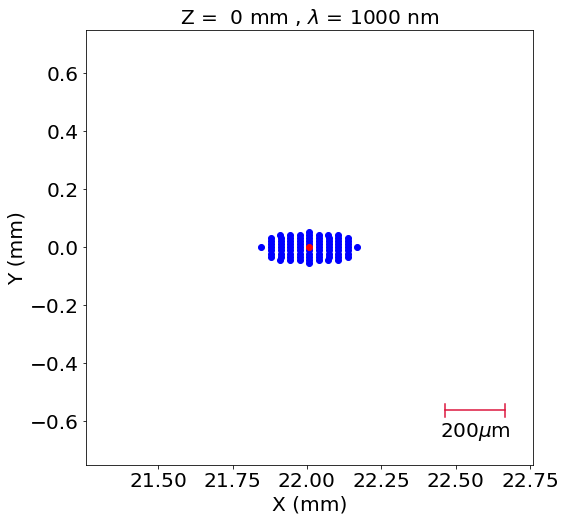

In [87]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
PlotBeamSpot(ax,all_Xi,all_Yi,X0,Y0,wave=0.001,defocus=0,scale=1.5)

In [88]:
all_Xi,all_Yi,X0,Y0=GetBeamSpot(df_R400,defocus=0,wave=0.001)

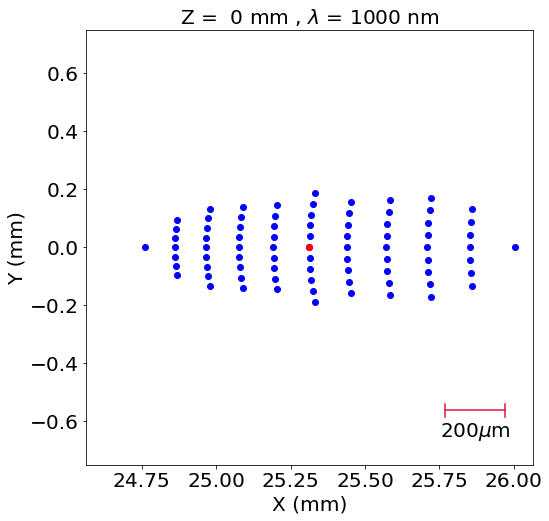

In [89]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
PlotBeamSpot(ax,all_Xi,all_Yi,X0,Y0,defocus=0,wave=0.001,scale=1.5)

# Loop on focal plane focus shift

- blue line : 400 nm
- green line : 600 nm
- red line : 800 nm
- black line : 1000 nm

In [90]:
all_Zfocus=np.arange(-15,5,1)  # from -15 mm to 5 mm step 200 microns, thus 75 points

In [91]:
Nfocus=len(all_Zfocus)

In [92]:
Nfocus

20

In [93]:
from ipywidgets import interactive

In [94]:
def ShowBeamSpot(df, dz,w,s):
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    all_Xi,all_Yi,X0,Y0=GetBeamSpot(df,defocus=dz,wave=w)
    PlotBeamSpot(ax,all_Xi,all_Yi,X0,Y0,defocus=dz,wave=w,scale=s)
    plt.show()

In [95]:
def ShowBeamSpot2(ax,df, dz,w,s):
    all_Xi,all_Yi,X0,Y0=GetBeamSpot(df,defocus=dz,wave=w)
    PlotBeamSpot2(ax,all_Xi,all_Yi,X0,Y0,defocus=dz,scale=s)

In [96]:
def ShowBeamSpotR400wl1000(dz):
    ShowBeamSpot(df_R400,dz,w=0.001,s=2.0)

In [97]:
def ShowBeamSpotR400wl600(dz):
    ShowBeamSpot(df_R400,dz,w=0.0006,s=1.0)

In [98]:
def ShowBeamSpotHOEwl1000(dz):
    ShowBeamSpot(df_hoe,dz,w=0.001,s=2.0)

In [99]:
def ShowBeamSpotHOEwl600(dz):
    ShowBeamSpot(df_hoe,dz,w=0.0006,s=1.0)

In [100]:
interactive_plot = interactive(ShowBeamSpotR400wl1000, dz=(-15.0, 5.0,0.1))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=-5.0, description='dz', max=5.0, min=-15.0), Output(layout=Layout(heig…

In [109]:
interactive_plot = interactive(ShowBeamSpotR400wl600, dz=(-10.0, 0,0.5))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=-5.0, description='dz', max=0.0, min=-10.0, step=0.5), Output(layout=L…

In [107]:
interactive_plot = interactive(ShowBeamSpotHOEwl1000, dz=(-15.0, 5.0,0.1))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=-5.0, description='dz', max=5.0, min=-15.0), Output(layout=Layout(heig…

In [103]:
interactive_plot = interactive(ShowBeamSpotHOEwl600, dz=(-15.0, 5.0,0.1))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(FloatSlider(value=-5.0, description='dz', max=5.0, min=-15.0), Output(layout=Layout(heig…

In [104]:
def PlotVignettes(df,w,s=1.5,title="",figname="beamspot.pdf"):
    """
    """
    dz=np.arange(-15.0, 5.0,1)
    N=len(dz)
    
    f, axarr = plt.subplots(5,4,sharey=True,figsize=(20,26))
    
    for j in np.arange(0,5):
        for i in np.arange(0,4):
            idx=j*4+i
            defocus=dz[idx]
            ShowBeamSpot2(axarr[j,i],df, defocus,w,s)
            axarr[j,i].set_aspect("equal")
            
    plt.tight_layout()
    plt.suptitle(title,fontsize=25,Y=1.00)
    plt.savefig(figname)
        

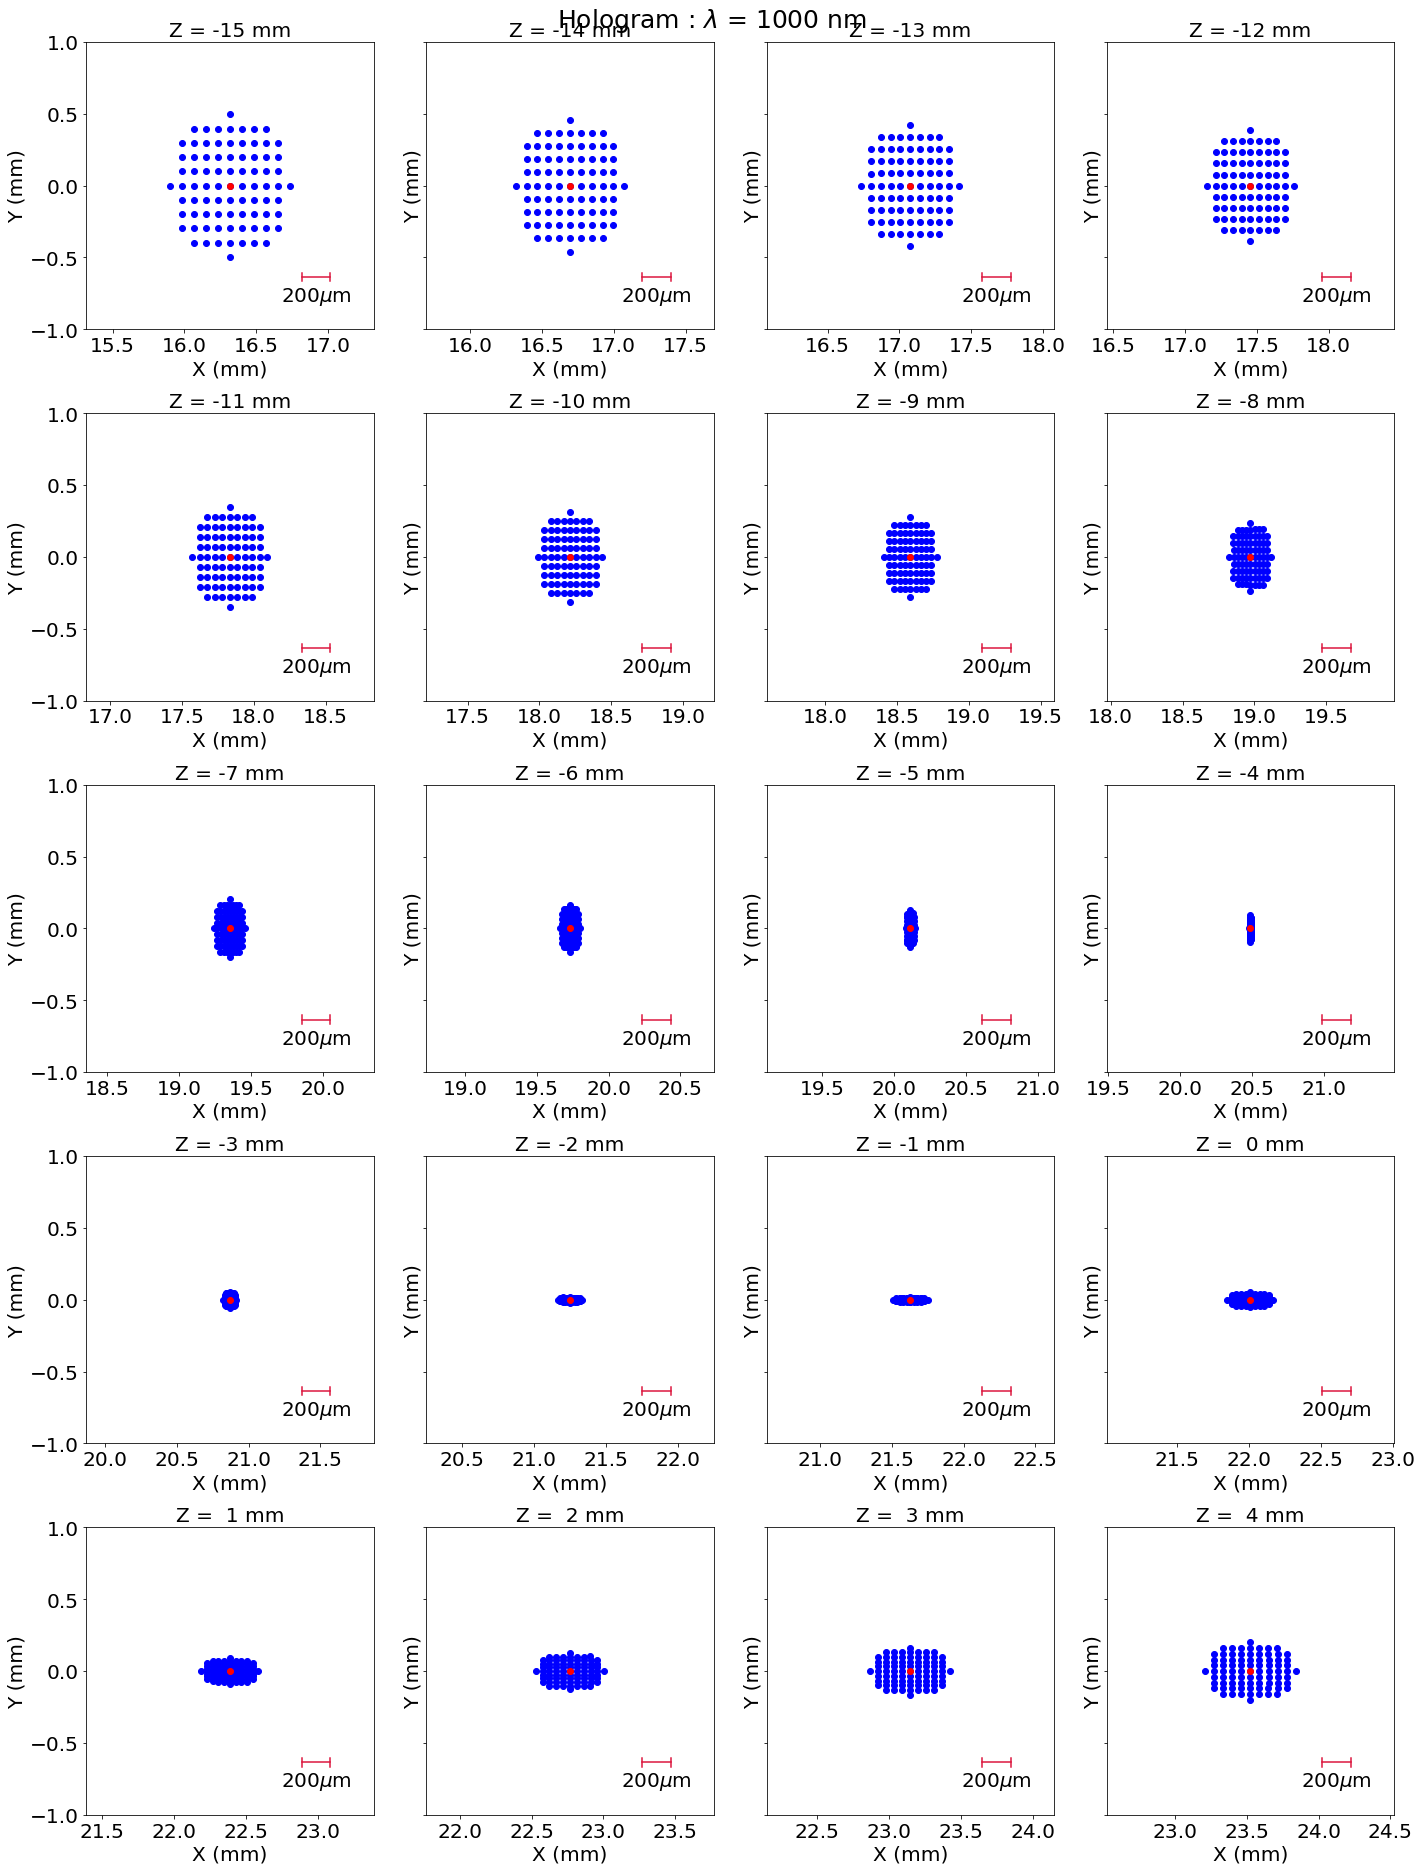

In [105]:
wave=0.001
title="Hologram : $\lambda$ = {:3.0f} nm".format(wave*1e6)
PlotVignettes(df_hoe,wave,s=2.0,title=title,figname="BeamSpotFocus_HOE_wl1000.pdf")

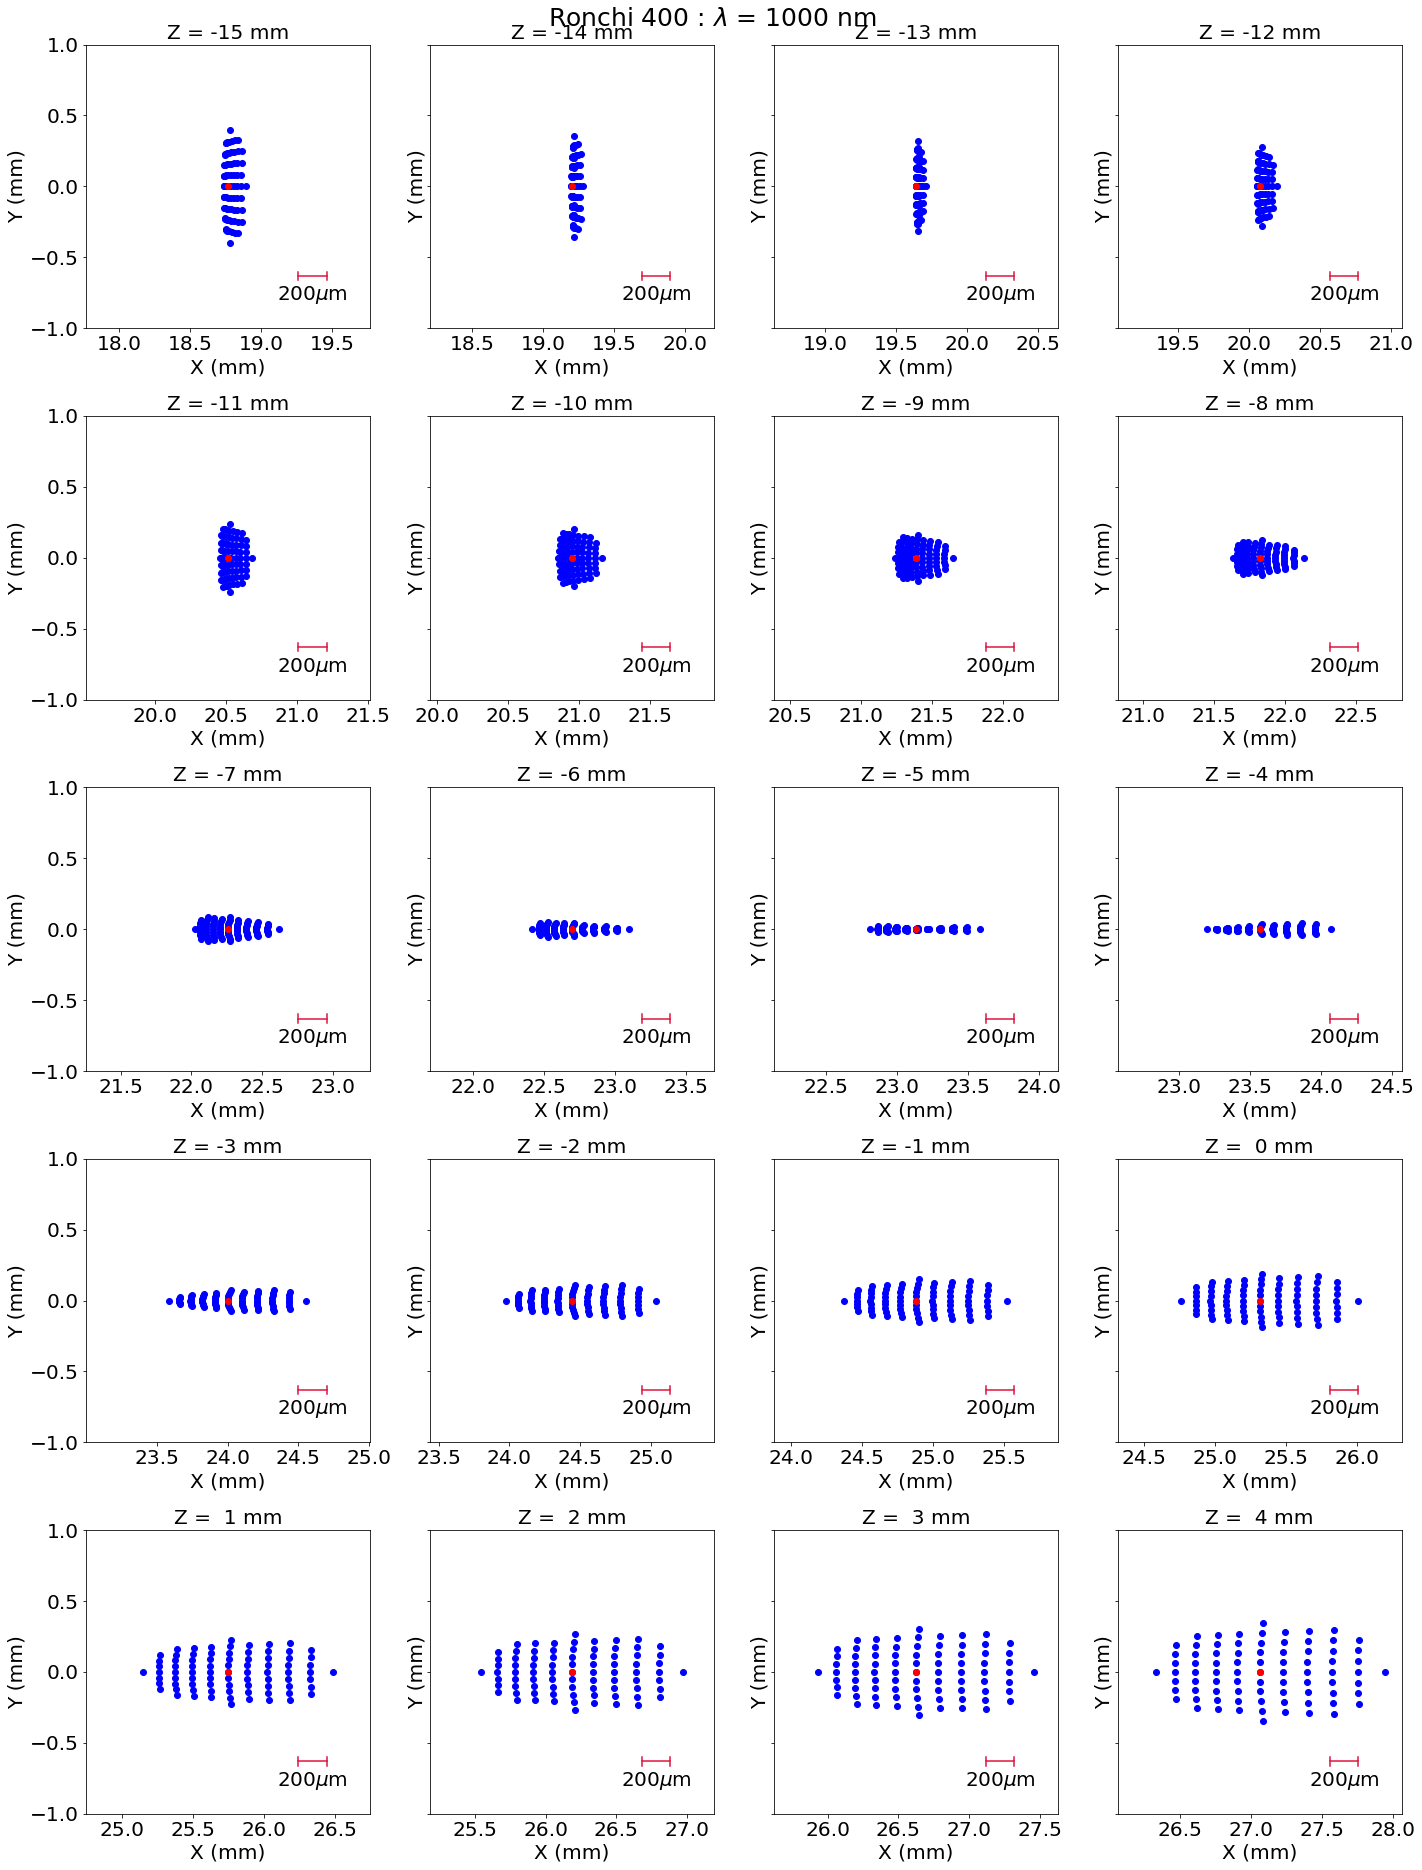

In [106]:
wave=0.001
title="Ronchi 400 : $\lambda$ = {:3.0f} nm".format(wave*1e6)
PlotVignettes(df_R400,wave,s=2.0,title=title,figname="BeamSpotFocus_R400_wl1000.pdf")